In [1]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [174]:
#
# Real ticker data
#
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.now()

#price_data = data.DataReader('AAPL', 'yahoo', start, end)
#adjclose_series = price_data['Adj Close']
#adjclose_series.name = 'close'

#df = pd.DataFrame(adjclose_series)
#
#

strategyname = 'strategy_340240'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo / 100

box_size = 2

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

column_flag = None

reversal_value = box_size * 3

reversal_flag = False

column_index = 0

# Simple point and figure algorihtm

for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start

        # First of all we need to set box size.
        # Then calculate price movement.
        # If price movement is more or equal than box size - renko bar(or bars) will be added

        if np.abs(price_move) >= box_size:

            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much pnf boxes will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_date = df.close.index[i]

            if column_flag == 'x' and reversal_flag == False:

                # Reversal check
                if price_move < 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move > 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == 'o' and reversal_flag == False:

                # Reversal check
                if price_move > 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move < 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):
                        d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                             'type': column_flag, 'column_index': column_index}

                        box_end = d['close']
                        temp_l.append(d)

            if column_flag == None and reversal_flag == False:

                # Adding first column

                if price_move > 0:
                    column_flag = 'x'

                if price_move < 0:
                    column_flag = 'o'

                for b in range(int(box_quantity)):
                    if column_flag == 'x':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                    if column_flag == 'o':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            # Handling the reversals
            if reversal_flag == True:
                column_index += 1
                
                if column_flag == 'x':

                    column_flag = 'o'

                    for b in range(int(box_quantity)):
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                elif column_flag == 'o':

                    column_flag = 'x'

                    for b in range(int(box_quantity)):
                        d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                             'type': column_flag, 'column_index': column_index}

                        box_end = d['close']
                        temp_l.append(d)

                reversal_flag = False
        try:
            box_start = temp_l[-1]['close']
            
        except IndexError:
            box_start = df.close[i]
            
pnf_df = pd.DataFrame(temp_l)                
pnf_df.index = pnf_df.column_index

pnf_last_column_value_df = pnf_df.groupby(pnf_df.index).last()
pnf_first_column_value_df = pnf_df.groupby(pnf_df.index).first()

In [191]:
((np.abs(df.min()) + np.abs(df.max())) / 2).values[0]

124.75000000000001

# Patterns

In [176]:
# New x column

pnf_prev1_df = pnf_df.shift(1)

#pnf_prev1_last_column_value_df = pnf_df.shift(1).groupby(pnf_df.index).last()

pnf_df['new_x_col'] = (pnf_df.type == 'x') & (pnf_df.type.shift(1) == 'o')
pnf_df['new_o_col'] = (pnf_df.type == 'o') & (pnf_df.type.shift(1) == 'x')

In [177]:
pnf_df['tripple_top'] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close == \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)

pnf_df['tripple_top'] = pnf_df['tripple_top'].fillna(False)

pnf_df['tripple_top_price_level'] = pnf_df[pnf_df.tripple_top == True].groupby(pnf_df[pnf_df.tripple_top == True].index).last().close
pnf_df['tripple_top_price_level'] = pnf_df['tripple_top_price_level'].ffill()

pnf_df['tripple_top_breakout'] =((pnf_df.close == pnf_df.tripple_top_price_level) & (pnf_df.close.shift(1) < pnf_df.tripple_top_price_level) 
                                & (pnf_df.tripple_top==False))

In [178]:
pnf_df['tripple_bot'] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'o'].close == \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'o'].close.shift(1)
    
pnf_df['tripple_bot'] = pnf_df['tripple_bot'].fillna(False)

pnf_df['tripple_bot_price_level'] = pnf_df[pnf_df.tripple_bot == True].groupby(pnf_df[pnf_df.tripple_bot == True].index).last().close
pnf_df['tripple_bot_price_level'] = pnf_df['tripple_bot_price_level'].ffill()

pnf_df['tripple_bot_breakout'] =((pnf_df.close == pnf_df.tripple_bot_price_level) & (pnf_df.close.shift(1) > pnf_df.tripple_bot_price_level) 
                                & (pnf_df.tripple_bot==False))

In [179]:
pnf_df[pnf_df.tripple_bot == True].groupby(pnf_df[pnf_df.tripple_bot == True].index).last()

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,tripple_bot,tripple_bot_price_level,tripple_bot_breakout
column_index,,,,,,,,,,,,,
38,-215.0625,38,2015-08-24,-213.0625,o,False,False,False,NaN,False,True,-215.0625,False
44,-191.0625,44,2016-02-24,-189.0625,o,False,False,False,NaN,False,True,-191.0625,False


In [180]:
pnf_df[pnf_df.tripple_top_breakout == True]

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,tripple_bot,tripple_bot_price_level,tripple_bot_breakout
column_index,,,,,,,,,,,,,


In [181]:
pnf_df[pnf_df.tripple_bot_breakout == True]['tripple_bot_price_level'].duplicated()

Series([], Name: tripple_bot_price_level, dtype: bool)

In [188]:
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

ddd = d.join(pnf_df.set_index('date')[['new_x_col', 'new_o_col', 'tripple_bot_breakout', 'tripple_top_breakout']])
ddd.new_o_col == True

2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-16    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23    False
2012-01-24    False
2012-01-25    False
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-31    False
2012-02-01    False
2012-02-02    False
2012-02-03    False
              ...  
2016-03-16    False
2016-03-17    False
2016-03-18    False
2016-03-21    False
2016-03-21    False
2016-03-22    False
2016-03-23    False
2016-03-24    False
2016-03-25    False
2016-03-28    False
2016-03-29    False
2016-03-30    False
2016-03-31    False
2016-04-01    False
2016-04-04    False
2016-04-05    False
2016-04-06    False
2016-04-07    False
2016-04-08    False


In [5]:
var = pnf_df[(pnf_df.close == pnf_df.close.rolling(len(pnf_df.close) * 0.01).min()) == True]
#var.index.unique()

#var = pnf_df[(pnf_df.close == pnf_df.close.expanding().max()) == True]

for i in var.index.unique():
    
    if i > 0:
                  
        pnf_df['test_trendline_'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
        pnf_df.loc[i-1, 'test_trendline_'+str(i)] = pnf_df.close[i-1]

        pnf_df.loc[i, 'test_trendline_'+str(i)] = pnf_first_column_value_df.close[i]

        pnf_df['test_trendline_'+str(i)] = pnf_df['test_trendline_'+str(i)].groupby(
            pnf_df['test_trendline_'+str(i)].index).last().interpolate('barycentric')

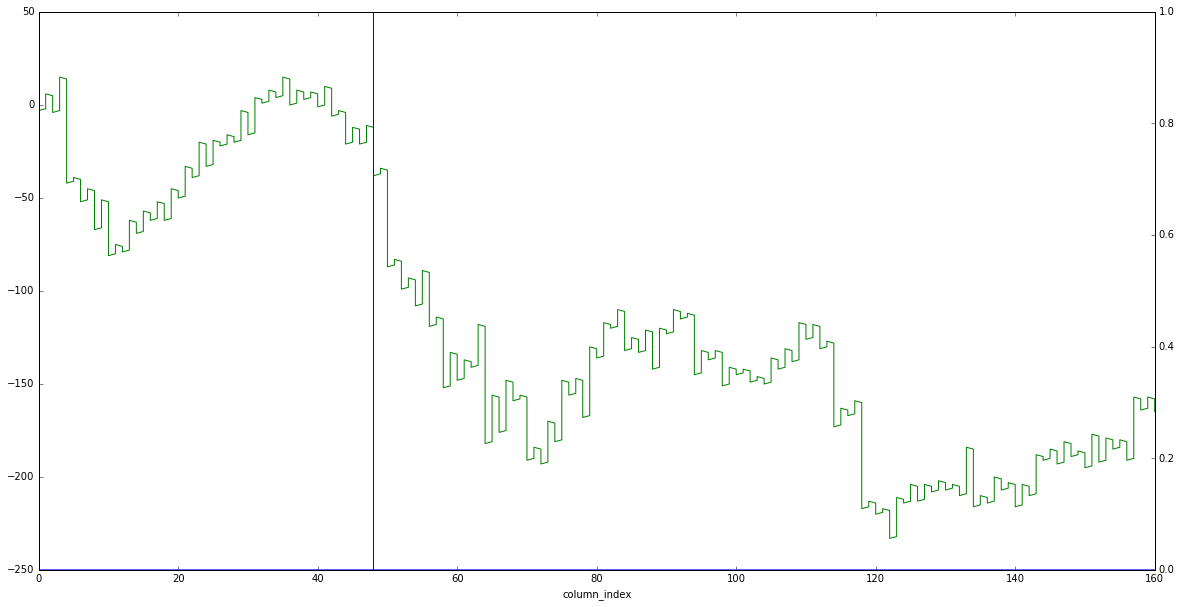

In [161]:
figsize(20,10)
pnf_df.tripple_bot_breakout.plot(secondary_y=True)
pnf_df.close.plot(legend=False)

In [24]:
close_prices_occurance = pnf_last_column_value_df.close.groupby(pnf_last_column_value_df.close).count()
close_prices_occurance[close_prices_occurance == 2]

close
76.434017     2
90.434017     2
95.434017     2
99.434017     2
100.434017    2
101.434017    2
104.434017    2
108.434017    2
110.434017    2
111.434017    2
114.434017    2
115.434017    2
116.434017    2
117.434017    2
123.434017    2
124.434017    2
125.434017    2
126.434017    2
128.434017    2
129.434017    2
148.434017    2
154.434017    2
180.434017    2
183.434017    2
191.434017    2
194.434017    2
198.434017    2
202.434017    2
203.434017    2
210.434017    2
dtype: int64

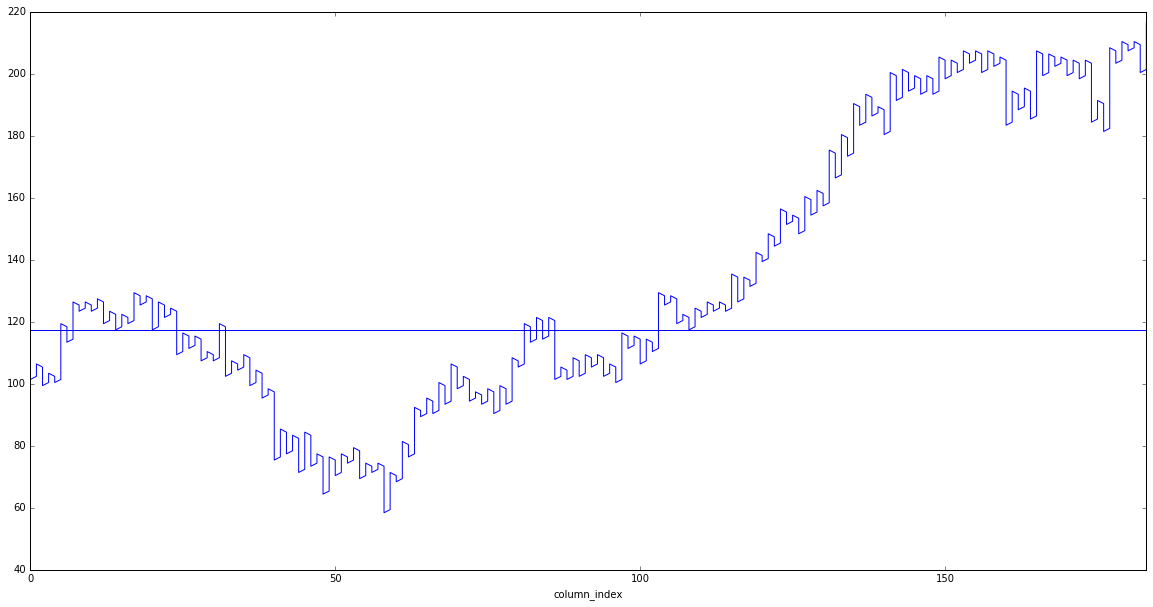

In [21]:
pnf_df.close.plot()

axhline(117.434017)
#axhline(109.434017)
#axhline(207.434017)
#axhline(-4920.0)

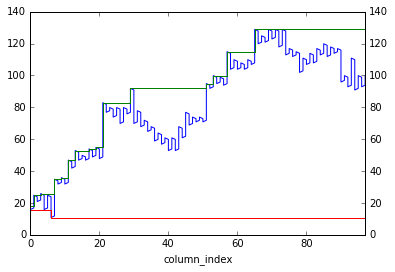

In [18]:
pnf_df.close.plot()
#(pnf_df.close == pnf_df.close.rolling(len(pnf_df.close) * 0.05).min()).plot(secondary_y=True)
(pnf_df.close.expanding().max()).plot(secondary_y=True)
(pnf_df.close.expanding().min()).plot(secondary_y=True)

In [36]:
(pnf_df.close == pnf_df.close.expanding().min()) == True

column_index
0       True
0       True
1      False
1      False
1      False
1      False
1      False
2      False
2      False
2      False
2      False
2       True
2       True
2       True
3      False
3      False
3      False
3      False
4      False
4      False
4      False
5      False
5      False
5      False
5      False
5      False
5      False
5      False
5      False
5      False
       ...  
180    False
181    False
181    False
181    False
182    False
182    False
182    False
182    False
182    False
182    False
182    False
182    False
182    False
182    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
183    False
Name: close, dtype: bool

In [42]:
pnf_df[pnf_df.close == pnf_df.close.min()]

,close,column_index,date,open,type
column_index,,,,,
58,58.434017,58,2009-03-09,59.434017,o


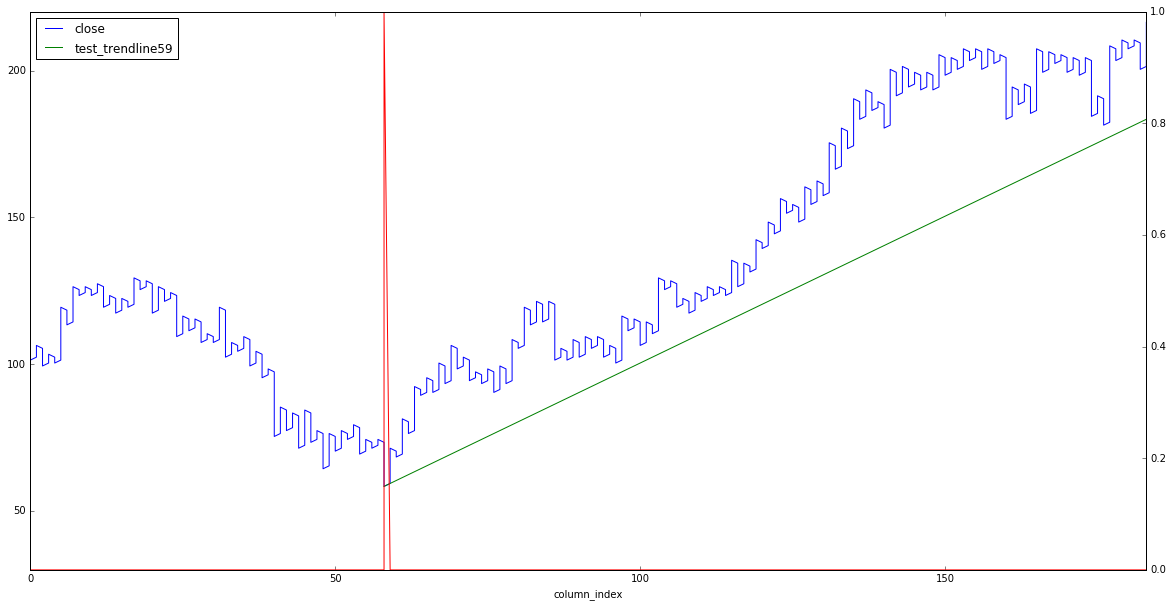

In [44]:
i=59

pnf_df['test_trendline'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
pnf_df.loc[i-1, 'test_trendline'+str(i)] = pnf_df.close[i-1]
pnf_df.loc[i, 'test_trendline'+str(i)] = pnf_first_column_value_df.close[i]

pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].groupby(
    pnf_df['test_trendline'+str(i)].index).last().interpolate('barycentric')

pnf_df.drop(['open', 'column_index'],1).plot(ylim=[30,220])
#(pnf_df.close == pnf_df.close.rolling(len(pnf_df.close) * 0.05).max()).plot(secondary_y=True)7
#(pnf_df.close == pnf_df.close.min()).plot(secondary_y=True)
(pnf_df.close == pnf_df.close.min()).plot(secondary_y=True)

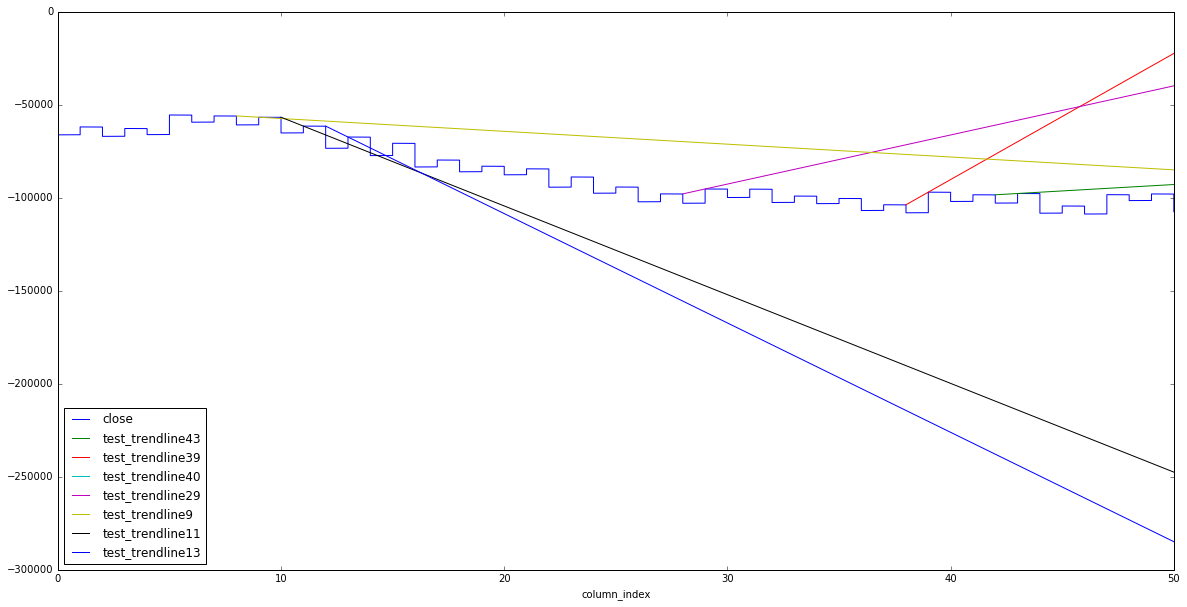

In [153]:
i=13

pnf_df['test_trendline'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
pnf_df.loc[i-1, 'test_trendline'+str(i)] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)[i]
pnf_df.loc[i, 'test_trendline'+str(i)] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close[i]

pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].groupby(
    pnf_df['test_trendline'+str(i)].index).last().interpolate('barycentric')

#pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].interpolate('barycentric')

#pnf_df['test_trendline'+str(i)].groupby(pnf_df['test_trendline'+str(i)].index).last().dropna()
pnf_df.drop(['open', 'column_index'],1).plot()

In [144]:
pnf_df.ix[39]

,close,column_index,date,open,type,test_trendline43
column_index,,,,,,
39,-107987.5,39,2015-08-20,-108017.5,x,NaN
39,-107957.5,39,2015-08-20,-107987.5,x,NaN
39,-107927.5,39,2015-08-20,-107957.5,x,NaN
39,-107897.5,39,2015-08-20,-107927.5,x,NaN
39,-107867.5,39,2015-08-20,-107897.5,x,NaN
39,-107837.5,39,2015-08-20,-107867.5,x,NaN
39,-107807.5,39,2015-08-20,-107837.5,x,NaN
39,-107777.5,39,2015-08-20,-107807.5,x,NaN
39,-107747.5,39,2015-08-20,-107777.5,x,NaN


In [132]:
pnf_df.ix[41]

,close,column_index,date,open,type,test_trendline24,test_trendline41
column_index,,,,,,,
41,76.434017,41,2008-10-13,75.434017,x,NaN,85.434017
41,77.434017,41,2008-10-13,76.434017,x,NaN,85.434017
41,78.434017,41,2008-10-13,77.434017,x,NaN,85.434017
41,79.434017,41,2008-10-13,78.434017,x,NaN,85.434017
41,80.434017,41,2008-10-13,79.434017,x,NaN,85.434017
41,81.434017,41,2008-10-13,80.434017,x,NaN,85.434017
41,82.434017,41,2008-10-13,81.434017,x,NaN,85.434017
41,83.434017,41,2008-10-13,82.434017,x,NaN,85.434017
41,84.434017,41,2008-10-13,83.434017,x,NaN,85.434017


In [147]:
pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close

column_index
1     -61847.5
3     -62687.5
5     -55427.5
7     -55937.5
9     -56627.5
11    -61397.5
13    -67277.5
15    -70637.5
17    -79637.5
19    -82967.5
21    -84377.5
23    -88757.5
25    -94157.5
27    -97847.5
29    -95207.5
31    -95297.5
33    -99017.5
35   -100307.5
37   -103697.5
39    -96917.5
41    -98327.5
43    -97637.5
45   -104357.5
47    -98267.5
49    -97877.5
Name: close, dtype: float64

In [78]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

py.sign_in('tmqr', '8rctfyu197')


trace1 = go.Scatter(
    x = pnf_df[pnf_df.type == 'o'].index,
    y = pnf_df[pnf_df.type == 'o'].close,
    name='Down',
    mode = 'markers',
    marker = dict(symbol="o", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'o'].date
)

trace2 = go.Scatter(
    x = pnf_df[pnf_df.type == 'x'].index,
    y = pnf_df[pnf_df.type == 'x'].close,
    name = 'Up',
    mode = 'markers',
    marker = dict(symbol="x", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'x'].date
    ) 

xo = [trace1, trace2]

layout = go.Layout(
    title="Point And Figure",
    xaxis=dict( autotick=True, autorange=True
        )
    )
fig = go.Figure(data=xo, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [8]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

In [16]:
pnf_df.ix[27]

,close,column_index,date,open,type
column_index,,,,,
27,70.896242,27,2012-05-21,69.896242,x
27,71.896242,27,2012-05-21,70.896242,x
27,72.896242,27,2012-05-21,71.896242,x
27,73.896242,27,2012-05-23,72.896242,x
27,74.896242,27,2012-05-23,73.896242,x
27,75.896242,27,2012-05-30,74.896242,x
27,76.896242,27,2012-06-18,75.896242,x
27,77.896242,27,2012-07-02,76.896242,x
27,78.896242,27,2012-07-05,77.896242,x


In [17]:
9

9

In [15]:
34+23

57